# <center>Flowers of New Forest

In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

### Create directories and copy in data

In [5]:
def folder_creater(folder, directory, SPLIT_SIZE = 0.8):
    
    parent_dir = os.getcwd()
    path = os.path.join(parent_dir, directory)

    # Empty directory to prevent FileExistsError is the function is run several times
    if os.path.exists(path):
      shutil.rmtree(path)
    
    # Create top directory
    os.makedirs(path)
    path = os.path.join(parent_dir, directory)
    
    # Find name of labels for folder names
    path_images = parent_dir + '/' + folder
    _tmp = os.listdir(path_images)
    _tmp.remove('.DS_Store')
    
    # Create the training and validation subdirectories
    training = os.path.join(path, 'training')
    os.makedirs(training)
    validation = os.path.join(path, 'validation')
    os.makedirs(validation)

    # Loop over all different labels
    for i in range(len(_tmp)):
        
        # Create subdirectories with name of labels in training
        # and validation folders
        new_train = os.path.join(training, _tmp[i])
        os.makedirs(new_train)
        new_validation = os.path.join(validation, _tmp[i])
        os.makedirs(new_validation)
        
        # Find names of image files
        _sub_folder = os.path.join(path_images, _tmp[i])
        _files = os.listdir(_sub_folder)
        
        # Shuffle the files
        random.sample(_files, len(_files))
        
        # Split into training and validation sets
        _train = _files[:int(SPLIT_SIZE*len(_files))]
        _validation = _files[int(SPLIT_SIZE*len(_files)):]
        
        # Copy files from original folders to new directories that
        # have been created for use with ImageGenerator
        for _file in _train:
            copyfile(_sub_folder + '/' + _file, new_train + '/' + _file)
        for _file in _validation:
            copyfile(_sub_folder + '/' + _file, new_validation + '/' + _file)
        
        # Check that the number of images matches the expected output
        print(f"\n\nThere are {len(os.listdir(new_train))} images of {_tmp[i]} for training")
        print(f"There are {len(os.listdir(new_validation))} images of {_tmp[i]} for validation")
        
    return training, validation

folder="images"
directory = "flower"

TRAIN_DIR, VALIDATION_DIR = folder_creater(folder,directory)



There are 272 images of weeds for training
There are 68 images of weeds for validation


There are 118 images of holly_hocks for training
There are 30 images of holly_hocks for validation


In [6]:
# Check the folders have been created succcessfully

parent_dir = os.getcwd()
directory = "flower"

path = os.path.join(parent_dir, directory)

for rootdir, dirs, files in os.walk(path):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/Users/lewishart/LinkedInLearning/Tensor_flow/flowers/flower/training
/Users/lewishart/LinkedInLearning/Tensor_flow/flowers/flower/validation
/Users/lewishart/LinkedInLearning/Tensor_flow/flowers/flower/training/weeds
/Users/lewishart/LinkedInLearning/Tensor_flow/flowers/flower/training/holly_hocks
/Users/lewishart/LinkedInLearning/Tensor_flow/flowers/flower/validation/weeds
/Users/lewishart/LinkedInLearning/Tensor_flow/flowers/flower/validation/holly_hocks


### Image augmentation

In [7]:
# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Pass in the appropiate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                  batch_size=8,
                                                  class_mode='binary',
                                                  target_size=(150, 150))

# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Pass in the appropiate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                            batch_size=8,
                                                            class_mode='binary',
                                                            target_size=(150, 150))

Found 388 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


### Get an idea of a good learning rate

In [22]:
def adjust_learning_rate(dataset):
    
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(units = 512, activation='relu'), 
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 4))
    
    model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
    
    history = model.fit(dataset, epochs=20, callbacks=[lr_schedule])
    
    return history

In [23]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_generator)

Epoch 1/20


2022-08-05 16:32:12.419054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 54s 1s/step - loss: 0.6299 - accuracy: 0.6856 - lr: 1.0000e-04
Epoch 2/20
49/49 [==============================] - 41s 830ms/step - loss: 0.5619 - accuracy: 0.7371 - lr: 1.7783e-04
Epoch 3/20
49/49 [==============================] - 41s 845ms/step - loss: 0.5149 - accuracy: 0.7706 - lr: 3.1623e-04
Epoch 4/20
49/49 [==============================] - 41s 839ms/step - loss: 0.3739 - accuracy: 0.8376 - lr: 5.6234e-04
Epoch 5/20
49/49 [==============================] - 41s 839ms/step - loss: 0.4193 - accuracy: 0.8299 - lr: 0.0010
Epoch 6/20
49/49 [==============================] - 41s 842ms/step - loss: 0.3982 - accuracy: 0.8454 - lr: 0.0018
Epoch 7/20
49/49 [==============================] - 41s 839ms/step - loss: 0.3179 - accuracy: 0.8789 - lr: 0.0032
Epoch 8/20
49/49 [==============================] - 41s 841ms/step - loss: 0.5892 - accuracy: 0.8222 - lr: 0.0056
Epoch 9/20
49/49 [==============================] - 41s 842ms/step - loss: 0.6921 - ac

(0.0001, 10.0, 0.0, 1.0)

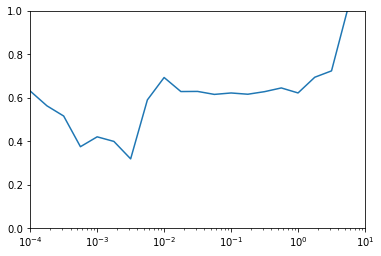

In [26]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 1])

### Vary parameters to find best model

In [8]:
def model_builder(hp):

    hp_units = hp.Float('units', min_value=0.0, max_value=0.3, step=0.1)
    
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(hp_units),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
    
    return(model)

In [9]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=3,
#                      directory='my_dir',
#                      project_name='flowers')

tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     directory='my_dir2',
                     project_name='flowers')

Metal device set to: Apple M1


2022-08-19 09:57:21.446178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-19 09:57:21.446879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
#Stop the training if the validation loss does not improve after epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tensor_board = tf.keras.callbacks.TensorBoard()

In [11]:
tuner.search(train_generator, epochs=50, validation_data = validation_generator, callbacks=[stop_early, tensor_board])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 16m 48s]
val_accuracy: 0.9693877100944519

Best val_accuracy So Far: 0.9897959232330322
Total elapsed time: 01h 14m 50s
INFO:tensorflow:Oracle triggered exit


In [12]:
print(f"""
The hyperparameter search is complete. The optimal number of dropout units in the first densely-connected
layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of dropout units in the first densely-connected
layer is 0.0.



### Build the model using the best parameters found earlier

In [14]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

model_weights = os.path.join(os.getcwd(), 'model_weights')
os.makedirs(model_weights)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_weights,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

history = model.fit(
            train_generator,
            epochs=50,
            validation_data=validation_generator,
            verbose=1,
            callbacks=[cp_callback]
            )

Epoch 1/50


2022-08-19 11:14:36.663520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 0.6338 - accuracy: 0.6907

2022-08-19 11:15:44.287152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.57572, saving model to /Users/lewishart/LinkedInLearning/Tensor_flow/flowers/model_weights
49/49 [==============================] - 85s 2s/step - loss: 0.6338 - accuracy: 0.6907 - val_loss: 0.5757 - val_accuracy: 0.6837
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.7964
Epoch 2: val_loss improved from 0.57572 to 0.41331, saving model to /Users/lewishart/LinkedInLearning/Tensor_flow/flowers/model_weights
49/49 [==============================] - 84s 2s/step - loss: 0.4620 - accuracy: 0.7964 - val_loss: 0.4133 - val_accuracy: 0.8673
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8505
Epoch 3: val_loss improved from 0.41331 to 0.25098, saving model to /Users/lewishart/LinkedInLearning/Tensor_flow/flowers/model_weights
49/49 [==============================] - 87s 2s/step - loss: 0.3620 - accuracy: 0.8505 - val_loss: 0.2510 - val_accuracy: 0.9082
Epoch 4/50
49/49 [==

### Visualize accuracy and loss as a function of epoch

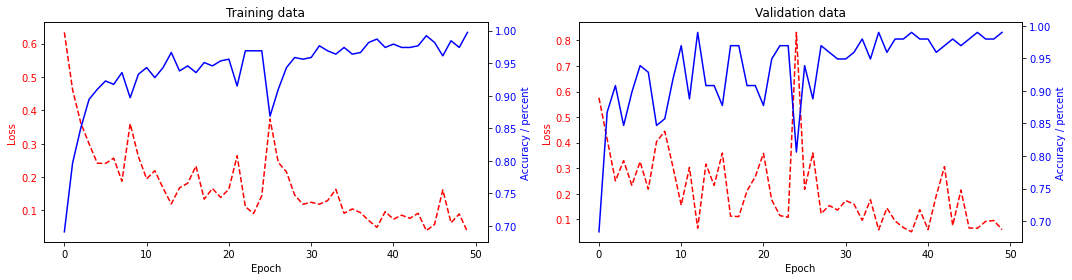

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Visualize loss  and accuracy history
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,4))
ax2 = ax[0].twinx()
ax[0].plot(history.history['loss'], 'r--',)
ax2.plot(history.history['accuracy'], 'b-')
ax[0].set_xlabel('Epoch')
ax[0].tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Accuracy / percent',c='b')
ax[0].set_ylabel('Loss', c='r')
ax2.tick_params(axis='y', labelcolor='b')
ax[0].set_title('Training data')

ax3 = ax[1].twinx()
ax[1].plot(history.history['val_loss'], 'r--',)
ax3.plot(history.history['val_accuracy'], 'b-')
ax[1].set_xlabel('Epoch')
ax[1].tick_params(axis='y', labelcolor='r')
ax3.tick_params(axis='y', labelcolor='b')
ax3.set_ylabel('Accuracy / percent',c='b')
ax[1].set_ylabel('Loss', c='r')
ax[1].set_title('Validation data')
plt.tight_layout()

In [23]:
# Create a basic model instance
model_best = tuner.hypermodel.build(best_hps)

# Loads the weights
model_best.load_weights(model_weights)

# Evaluate the model
loss, acc = model_best.evaluate(validation_generator, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

2022-08-19 12:20:55.100574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 - 10s - loss: 0.0731 - accuracy: 0.9796 - 10s/epoch - 794ms/step
Trained model, accuracy: 97.96%


### Test the model

2022-08-19 12:11:50.279135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.9631247]
[0.]


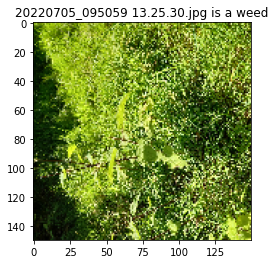

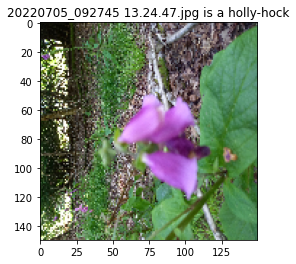

In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image

test_dir = os.path.join(parent_dir, 'test_images')
test_files = os.listdir(test_dir)
test_files.remove('.DS_Store')

for fn in test_files:
    # predicting images
    t = test_dir + '/' + fn
    img=image.load_img(t, target_size=(150, 150))

    x2=image.img_to_array(img)
    x2 /= 255
    x=np.expand_dims(x2, axis=0)
    images = np.vstack([x])

    classes = model_best.predict(images, batch_size=1, verbose=3)
    plt.figure()
    plt.imshow(x2)
    print(classes[0])

    if classes[0]>0.5:
        plt.title(fn + " is a weed")
    else:
        plt.title(fn + " is a holly-hock")